<html id="* graph_euler_method">
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>Sageでグラフを再現してみよう：データ解析のための統計モデリング入門第５章</h1>
	<p>
		この企画は、雑誌や教科書にでているグラフをSageで再現し、
		グラフの意味を理解すると共にSageの使い方をマスターすることを目的としています。
	</p>
	<p>
		前回に続き、<a href="http://www.amazon.co.jp/dp/400006973X/">データ解析のための統計モデリング入門</a>
		（以下、久保本と書きます）
		の第5章の例題をSageを使って再現してみます。
	</p>
	<p>
		私が統計を嫌いになったのは、χ二乗検定が原因です。
		どうしてそうなるのかも説明されないまま検定をすることに納得がいかず拒否していたのを覚えています。	
				
	</p>
	<p>
		久保本はそれをすぱっと解決してくれました。今回の目標はずばり図５．４です（久保本から引用）。
		<img src="images/Fig-5.4.png"/>
	</p>
	<p>
		数式処理システムSageのノートブックは、計算結果を表示するだけではなく、実際に動かすことができるのが大きな特徴です。
		この機会にSageを分析に活用してみてはいかがでしょう。
	</p>
</html>

<html>
	<h2>前準備</h2>
	<p>
		最初に必要なライブラリーやパッケージをロードしておきます。
	</p>
</html>

In [1]:
# RとPandasのデータフレームを相互に変換する関数を読み込む
# Rの必要なライブラリ
r('library(ggplot2)')
r('library(jsonlite)')

# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# statsmodelsを使ってglmを計算します
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
load('script/sage_util.py')
# Rユーティリティ
load('script/RUtil.py')

<html>
	<h2>尤度比検定がすごい</h2>
	<p>
		どんな統計モデルにも使える尤度比検定が、5章のテーマです。ターゲットの統計モデル（xモデル）と一定値を使った意味の無いモデル
		：帰無仮説の尤度比を使って帰無仮説棄却の可否を判断します。
		（久保本では「無に帰される」から帰無仮説と説明があり昔の人はよい名前を付けるなぁと感動！）
	</p>
	<p>
		今回は、3章の例題で一定モデルとｘモデルを比較します。対数尤度は、以下の様になり、
$$
	\frac{L^*_1}{L^*_2} = \frac{一定モデルの最大尤度}{ｘモデルの最大尤度}
$$	
		これの対数に-2を掛けた値（逸脱度の差）を使って検定をします。
$$
	\Delta D_{1,2} = -2 \times ( log L^*_1 - log L^*_2)
$$			
	</p>
	<p>
		逸脱度の差は、以下の計算で4.5とでました。
	</p>
</html>

In [2]:
# 3章のデータをもう一度読み込む
d = pd.read_csv('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/poisson/data3a.csv')

In [3]:
# 一定モデル（k=1）でのglm回帰を実行
fit1 = smf.glm('y ~ 1', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()

In [4]:
# xモデル
fit2 = smf.glm('y ~ x', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()

逸脱度の差$\Delta D_{1,2}$が4.5ぐらいと求まる。

In [5]:
# 逸脱度（-2logL）
-2*(fit1.llf - fit2.llf)

4.5139410788519854

In [6]:
# 一定モデル（fit1）の切片beta_2の推定値2.058となり、exp(2.058)がd.yの平均とほぼ一致していることを確認
fit1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            477.2864 
Link Function:      log              BIC:            -366.4049
Dependent Variable: y                Log-Likelihood: -237.64  
Date:               2016-07-17 06:17 LL-Null:        -237.64  
No. Observations:   100              Deviance:       89.507   
Df Model:           0                Pearson chi2:   87.1     
Df Residuals:       99               Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept     2.0580    0.0357  57.5862  0.0000  1.9879  2.1280
==============================================================

"""

In [7]:
print exp(2.058), d.y.mean()

7.83029355218137 7.83


<html>
	<h2>帰無仮説を棄却させる手順</h2>
	<p>
		第一種の過誤の検討に専念して、以下の手順で帰無仮説を棄却します。
		<ol>
			<li>帰無仮説（今回は一定モデル）が正しいものと仮定する</li>
			<li>観測データに帰無モデルをあてはめ、$\hat{\beta_1}=2.058$を得て、これが真のモデルとする</li>
			<li>上記の真のモデルからサンプルデータを生成し、その度に一定モデルをあてはめ、$\Delta D_{1,2}$を求め、その分布を求める</li>
			<li>求まった分布から一定モデル（帰無モデル）とxモデルの逸脱度の差$\Delta D_{1,2} \geq 4.5$となる確率Pを評価する</li>
		</ol>
	</p>
</html>

<html>
	<h3>サンプルの生成</h3>
	<p>
		Sageには、ポアソン分布を生成する関数が無いので、Rのrpois関数を使ってlambda_targetで指定されたλのサンプルを
		sample_size個生成する関数genSampleを以下の様に定義します。
	</p>
</html>

In [8]:
# Rの乱数の種をセット
r('set.seed(101)')
# sageobjを使って変換する方が速いのでgenSample関数を使用する
def genSample(lambda_target, sample_size):
    return np.array(sageobj(r('rpois(%d, %f)'%(sample_size, lambda_target))))

<html>
	<h3>パラメトリックブートストラップ法</h3>
	<p>
		パラメトリックブートストラップ法をSageで試してみます。4章のバイアスの計算と異なり、
		一定モデルを真のモデルとしてサンプルデータを生成し、一定モデルとxモデルにGLMを使って
		回帰分析を行い、対数尤度llfから逸脱度Dの差を求めます。
		これをn_bootstrap回繰り返し、その分布を求めます。
	</p>
</html>

In [9]:
# パラメトリックブートストラップ法
def pb(d, n_bootstrap):
    N = len(d)
    y_mean = d.y.mean()
    def sampling(d, y_mean, N):
        # 帰無仮説を真のモデルとしてサンプルデータを生成
        d['rnd'] = genSample(y_mean, N)
        fit1 = smf.glm('rnd ~ 1', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()
        fit2 = smf.glm('rnd ~ x', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit() 
        return -2*(fit1.llf - fit2.llf)
    return [ sampling(d, y_mean, N) for i in range(n_bootstrap)]


In [10]:
# 逸脱度の差を1000サンプル生成
dd12 = pb(d, 1000)

<html>
	<h3>サンプルの結果</h3>
	<p>
		ブートストラップ法で求まった結果にdescribe（Rのsummaryに相当）を使って分布の概要を把握し、
		ggplotのヒストグラムでその分布を表示してみます。
	</p>
</html>

In [11]:
dd12Df = pd.DataFrame({'x' : dd12})
dd12Df.describe()

,x
count,1000.000000
mean,0.988756
std,1.451894
min,0.000001
25%,0.079798
50%,0.412794
75%,1.236868
max,12.078559


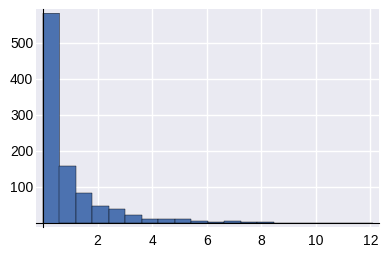

In [12]:
histogram(dd12, figsize=4, bins=20)

<html>
	<h3>仮説の検証</h3>
    <p>
      逸脱度の差$\Delta D_{1,2} \ge 4.5$となる確率Pをp値と呼びます。
    </p>
	<p>
		一定もでるとxモデルの逸脱度の差（4.5）以上のデータの個数は、41個でp値は、41/1000=0.041となり、95%となるｘの値は
		4.02と求まります。
	</p>
	<p>
		ｐ値（0.041）が有意水準5%（0.05）よりも小さいため、帰無仮説（一定モデル）は棄却され、xモデルが採択されました。
	</p>
</html>

In [13]:
# 4.5以上のデータの個数は
len(dd12Df[dd12Df.x >= 4.5])

41

In [14]:
# 95%となるxの値を求める
dd12Df.quantile(0.95)

x    4.022639
dtype: float64

<html>
	<h2>χ自乗分布を使かう方法</h2>
   <p>
       逸脱度の差$\Delta D_{1,2}$の確率分布は、自由度１の$\chi ^2$分布で近似できる場合があります。
       anovaにtest="Chisq"を渡してp値を計算します。
   </p>
	<p>
		残念ながら、statsmodelsにはglmに対するanovaがないため、Rにデータを渡して、計算しました。
		p値は、0.034となり、同様に帰無仮説は棄却されました。（Rを使っているので、久保本と同じ結果になるのは当然です。）
	</p>
</html>

$\chi ^2$分布の他に、anovaに渡す確率分布には以下のものがあります。
 - 平均の差を検定量とする場合、$t$分布
 - 分散比検定量とする場合、$F$分布


In [15]:
# Rにｄを渡して計算
PandaDf2RDf(d, "d")

In [16]:
# ANOVA(ANalysis Of VAriance)を使って逸脱度を調べる、Chisq（χ）でχ二乗分布近似を指定。
r('fit1 <- glm(y ~ 1, data=d, family=poisson)')
r('fit2 <- glm(y ~ x, data=d, family=poisson)')
r('anova(fit1, fit2, test = "Chisq")')

Analysis of Deviance Table

Model 1: y ~ 1
Model 2: y ~ x
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)  
1        99     89.507                       
2        98     84.993  1   4.5139  0.03362 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1